In [5]:
!pip install pyspark
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("DataManipulation").getOrCreate()
spark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import findspark
findspark.init()

In [ ]:
import pyspark
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder.master("local[*]").appName("TeamProject").getOrCreate()

In [ ]:
spark

In [6]:
df = spark.read.option("header","true").csv("googleplaystore.csv")

In [7]:
df.printSchema()

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Installs: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Current Ver: string (nullable = true)
 |-- Android Ver: string (nullable = true)



In [8]:
df=df.dropna()

In [9]:
df.dropDuplicates()

DataFrame[App: string, Category: string, Rating: string, Reviews: string, Size: string, Installs: string, Type: string, Price: string, Content Rating: string, Genres: string, Last Updated: string, Current Ver: string, Android Ver: string]

In [10]:
df.count()

10839

In [11]:
from pyspark.sql.types import StringType , IntegerType ,DoubleType
from pyspark.sql.functions import *
from pyspark.sql.functions import col, cast 

In [12]:
df = df.withColumn("Installs", regexp_replace("Installs", "\+", ""))
df = df.withColumn("Installs", regexp_replace("Installs", ",", ""))
df = df.withColumn("Installs", col("Installs").cast("integer"))

In [13]:
df = df.withColumn("Price", regexp_replace(col("Price"), "[^\d.]", ""))
df = df.withColumn("Price", col("Price").cast(DoubleType()))
df = df.na.fill(0, "Price")

In [14]:
df.printSchema()

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Installs: integer (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: double (nullable = false)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Current Ver: string (nullable = true)
 |-- Android Ver: string (nullable = true)



In [15]:
from pyspark.sql.functions import when
from pyspark.sql.functions import sum,avg,max,count

In [16]:
df.createOrReplaceTempView("gstore")

In [17]:
# Top 5 downloaded apps with spark (show to which category they belong to)
top_down = df.select(["Category","App","Installs"]).orderBy('Installs',ascending = False)
top_down.show(5)

+-------------------+--------------------+----------+
|           Category|                 App|  Installs|
+-------------------+--------------------+----------+
|      COMMUNICATION|            Hangouts|1000000000|
|      COMMUNICATION|  WhatsApp Messenger|1000000000|
|      COMMUNICATION|Google Chrome: Fa...|1000000000|
|BOOKS_AND_REFERENCE|   Google Play Books|1000000000|
|      COMMUNICATION|Messenger – Text ...|1000000000|
+-------------------+--------------------+----------+
only showing top 5 rows



In [18]:
# Top 5 downloaded apps with spark (show to which category they belong to) (sqlspark)
spark.sql("SELECT Category , App , Installs FROM gstore ORDER BY Installs desc limit 5").show()

+-------------------+--------------------+----------+
|           Category|                 App|  Installs|
+-------------------+--------------------+----------+
|      COMMUNICATION|               Gmail|1000000000|
|      COMMUNICATION|Google Chrome: Fa...|1000000000|
|BOOKS_AND_REFERENCE|   Google Play Books|1000000000|
|      COMMUNICATION|Messenger – Text ...|1000000000|
|      COMMUNICATION|            Hangouts|1000000000|
+-------------------+--------------------+----------+



In [19]:
spark.sql("SELECT COUNT(App) FROM gstore WHERE Installs =1000000000 ").show()

+----------+
|count(App)|
+----------+
|        58|
+----------+



In [20]:
# Highest paid categories with sqlspark
spark.sql("SELECT Category,COUNT(App) as Total_app FROM gstore WHERE Price > 0  group by Category order by Total_app desc").show(10)

+-------------------+---------+
|           Category|Total_app|
+-------------------+---------+
|             FAMILY|      191|
|            MEDICAL|      109|
|    PERSONALIZATION|       83|
|               GAME|       83|
|              TOOLS|       78|
|       PRODUCTIVITY|       28|
|BOOKS_AND_REFERENCE|       28|
|      COMMUNICATION|       27|
|             SPORTS|       24|
|        PHOTOGRAPHY|       22|
+-------------------+---------+
only showing top 10 rows



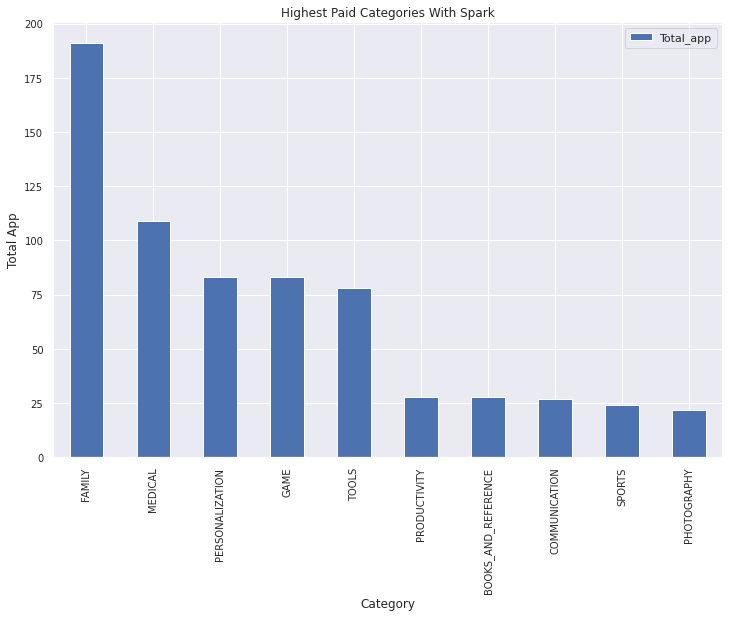

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

result = spark.sql("SELECT Category,COUNT(App) as Total_app FROM gstore WHERE Price > 0  group by Category order by Total_app desc limit 10").toPandas()

result.plot(kind = 'bar', x='Category', y='Total_app',title='Highest Paid Categories With Spark', fontsize=10, figsize = (12, 8));
plt.xlabel('Category')
plt.ylabel('Total App');